<a href="https://colab.research.google.com/github/XiaonanLu/BNN-Time-Series/blob/main/notebooks/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
import subprocess
import pandas as pd

DATA = 'data'
DATASET = 'Metro_Interstate_Traffic_Volume.csv'
# create data dir
Path(DATA).mkdir(parents=True, exist_ok=True)

# download and extract data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'
subprocess.run(['curl', '-o', f'{DATA}/{DATASET}.gz', url])
subprocess.run(['gzip', '-d', f'{DATA}/{DATASET}.gz'])

# read in data with pandas
df = pd.read_csv(f'{DATA}/{DATASET}')
df.head(3)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767


In [2]:
time_col = 'date_time'
# cast date_time to time type
df[time_col] = pd.to_datetime(df[time_col])
# sort dataframe by time
df = df.sort_values(time_col)

In [3]:
df[df[time_col].duplicated(keep=False)].head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
178,None,281.25,0.0,0.0,99,Rain,light rain,2012-10-10 07:00:00,6793
179,None,281.25,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 07:00:00,6793
180,None,280.10,0.0,0.0,99,Rain,light rain,2012-10-10 08:00:00,6283
181,None,280.10,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 08:00:00,6283
182,None,279.61,0.0,0.0,99,Rain,light rain,2012-10-10 09:00:00,5680
183,None,279.61,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 09:00:00,5680
269,None,282.43,0.0,0.0,57,Drizzle,light intensity drizzle,2012-10-14 09:00:00,2685
270,None,282.43,0.0,0.0,57,Mist,mist,2012-10-14 09:00:00,2685
271,None,282.43,0.0,0.0,57,Haze,haze,2012-10-14 09:00:00,2685
272,None,282.33,0.0,0.0,57,Drizzle,light intensity drizzle,2012-10-14 10:00:00,3370


In [4]:
df = df.iloc[df[time_col].drop_duplicates(keep='last').index]

In [5]:
# get the first and last timestamps
start, end = df.date_time.iloc[[0,-1]].values

# get a list of hourly timestamps in this range
full_range = pd.date_range(start, end, freq='H')

full_range.shape[0], full_range.shape[0]- df.shape[0]
(52551, 11976)

(52551, 11976)

In [6]:
df = pd.DataFrame(full_range, columns=[time_col]).merge(df, on=time_col, how='outer')
df = df.set_index(time_col)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40.0,Clouds,scattered clouds,5545.0
2012-10-02 10:00:00,None,289.36,0.0,0.0,75.0,Clouds,broken clouds,4516.0
2012-10-02 11:00:00,None,289.58,0.0,0.0,90.0,Clouds,overcast clouds,4767.0
2012-10-02 12:00:00,None,290.13,0.0,0.0,90.0,Clouds,overcast clouds,5026.0
2012-10-02 13:00:00,None,291.14,0.0,0.0,75.0,Clouds,broken clouds,4918.0


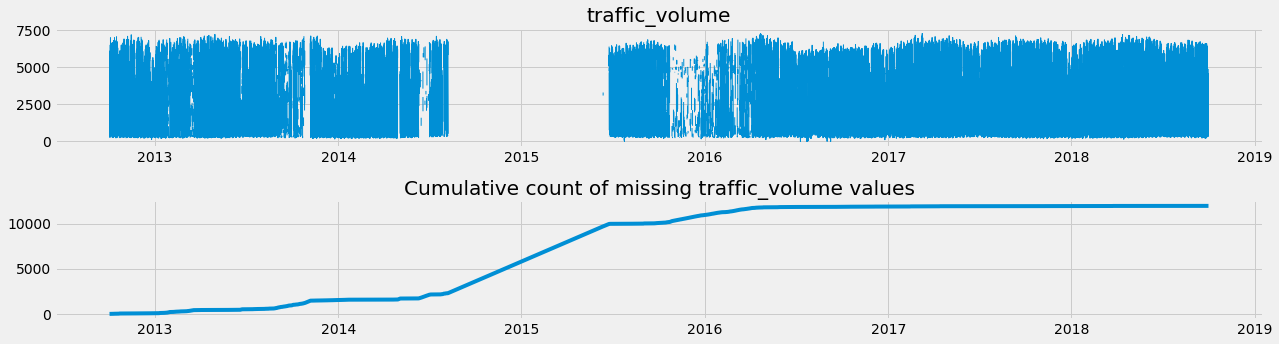

In [7]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
plt.style.use('fivethirtyeight')

response_col = 'traffic_volume'

fig,axs = plt.subplots(2, 1, figsize=(18,5))
axs[0].plot(df[response_col],'-', lw=1)
axs[0].set_title(response_col)
axs[1].plot(np.cumsum(df[response_col].isna()),'-')
axs[1].set_title(f'Cumulative count of missing {response_col} values')
plt.tight_layout()


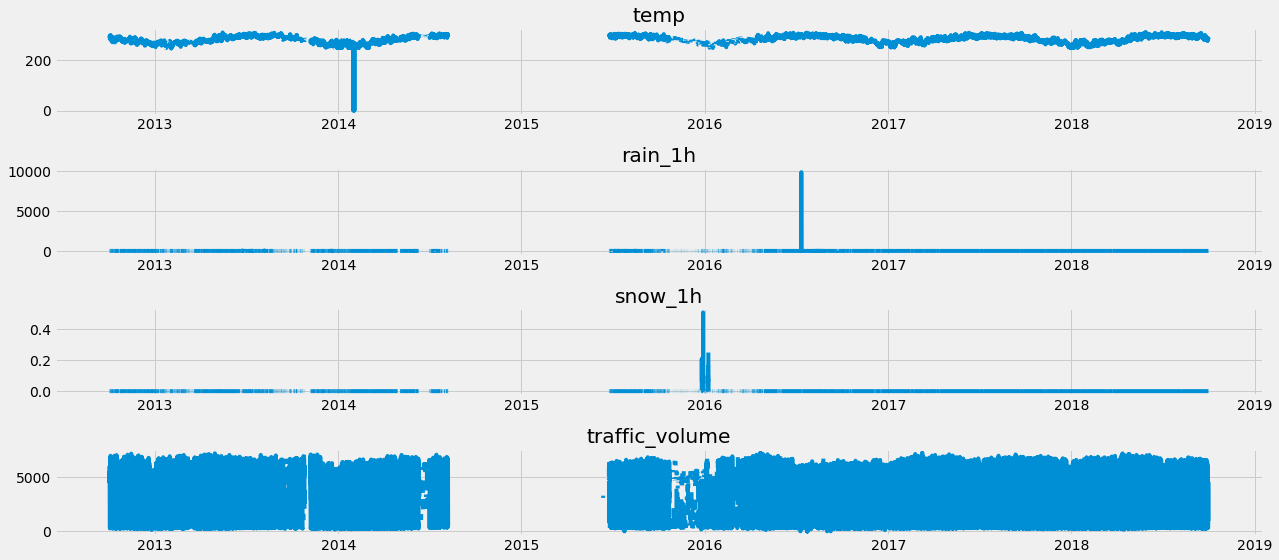

In [8]:
columns = ['temp', 'rain_1h', 'snow_1h', 'traffic_volume']
fig, axs = plt.subplots(len(columns), 1, figsize=(18,len(columns)*2))
for c,col in enumerate(columns):
    axs[c].plot(df[col])
    axs[c].set_title(col)
plt.tight_layout()

In [9]:
# get the second largest rain value
second_largest_rain_1h = df['rain_1h'].sort_values(ascending=False)[1]
second_largest_rain_1h

rain_1h_mask = df['rain_1h'] > 5000
largest_rain_1h_idx = np.where(rain_1h_mask)[0][0]

df.at[df.iloc[largest_rain_1h_idx].name, 'rain_1h'] = second_largest_rain_1h

In [10]:
temp_mask = df['temp'] < 100
smallest_temp_idx = np.where(temp_mask)[0][0]
df.iloc[smallest_temp_idx-1:smallest_temp_idx+5][['temp']]

# get interpolated value
temp_imputate_value = df['temp'].iloc[[smallest_temp_idx-1,smallest_temp_idx+5]].mean()

# fill in anomalous values
for i in range(smallest_temp_idx,smallest_temp_idx+4):
    idx = df.iloc[i].name
    df.at[idx, 'temp'] = temp_imputate_value

df.iloc[smallest_temp_idx-1:smallest_temp_idx+5][['temp']]


,temp
date_time,
2014-01-31 02:00:00,255.93
2014-01-31 03:00:00,255.93
2014-01-31 04:00:00,255.93
2014-01-31 05:00:00,255.93
2014-01-31 06:00:00,255.93
2014-01-31 07:00:00,255.93


In [11]:
df['weather_description'].unique()


array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', nan, 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog', 'drizzle',
       'moderate rain', 'proximity thunderstorm',
       'proximity thunderstorm with rain', 'heavy snow',
       'heavy intensity rain', 'snow', 'shower snow',
       'light rain and snow', 'SQUALLS', 'thunderstorm with heavy rain',
       'thunderstorm with rain', 'thunderstorm with light rain',
       'heavy intensity drizzle', 'Sky is Clear',
       'thunderstorm with light drizzle', 'thunderstorm',
       'very heavy rain', 'proximity thunderstorm with drizzle',
       'light snow', 'proximity shower rain',
       'light intensity shower rain', 'light shower snow', 'smoke',
       'shower drizzle'], dtype=object)

In [14]:
dummies = pd.get_dummies(df['weather_description'], prefix='weather')
dummies.head()

,weather_SQUALLS,weather_Sky is Clear,weather_broken clouds,weather_drizzle,weather_few clouds,weather_fog,weather_haze,weather_heavy intensity drizzle,weather_heavy intensity rain,weather_heavy snow,...,weather_shower snow,weather_sky is clear,weather_smoke,weather_snow,weather_thunderstorm,weather_thunderstorm with heavy rain,weather_thunderstorm with light drizzle,weather_thunderstorm with light rain,weather_thunderstorm with rain,weather_very heavy rain
date_time,,,,,,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-02 10:00:00,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-02 11:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-02 12:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-10-02 13:00:00,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df[dummies.columns] = dummies

In [17]:

df['holiday'].unique()
dummies = pd.get_dummies(df['holiday'], prefix='holiday')
df[dummies.columns] = dummies

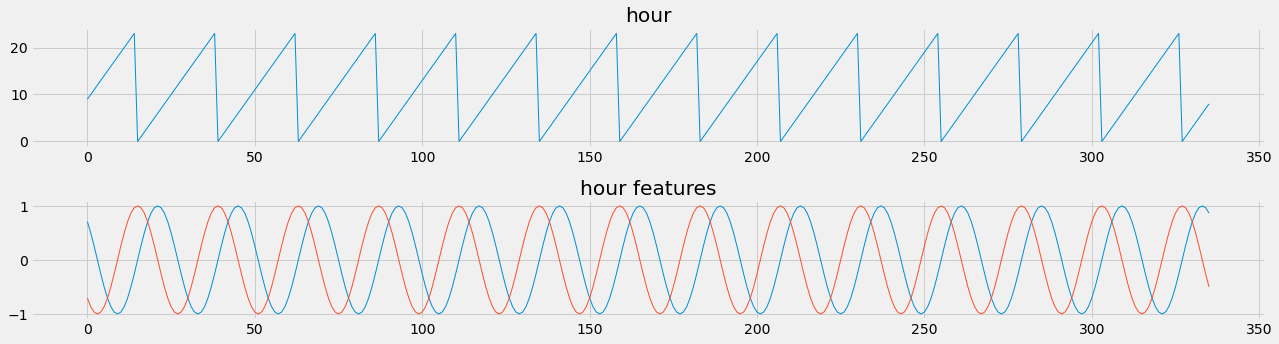

In [18]:
hour_sin = np.sin(2*np.pi*(df.index.hour.values/24))
hour_cos = np.cos(2*np.pi*(df.index.hour.values/24))

fig,axs = plt.subplots(2, 1, figsize=(18,5))
axs[0].plot(df.index.hour[:24*7*2],'-', lw=1)
axs[0].set_title('hour')
axs[1].plot(hour_sin[:24*7*2],'-', lw=1)
axs[1].plot(hour_cos[:24*7*2],'-', lw=1)
axs[1].set_title('hour features')
plt.tight_layout()

In [19]:
df['hour_sin'] = hour_sin
df['hour_cos'] = hour_cos

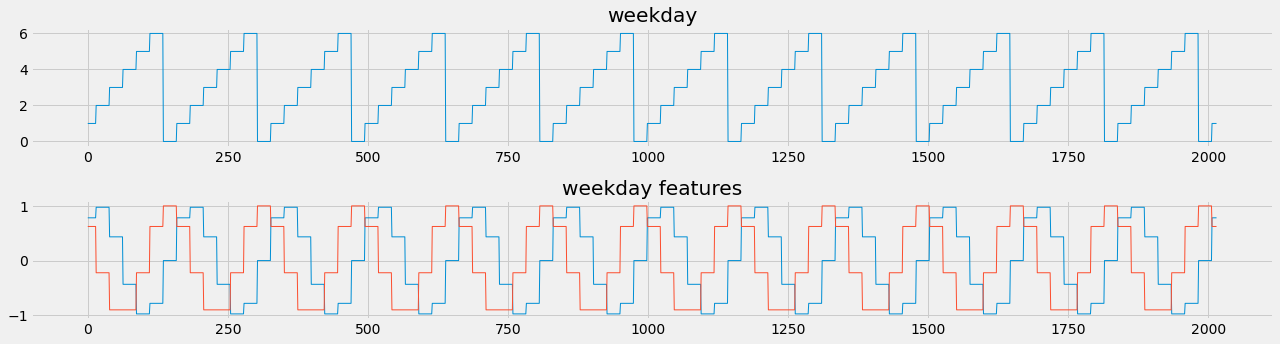

In [20]:
weekday_sin = np.sin(2*np.pi*(df.index.weekday.values/7))
weekday_cos = np.cos(2*np.pi*(df.index.weekday.values/7))

fig,axs = plt.subplots(2, 1, figsize=(18,5))
axs[0].plot(df.index.weekday[:24*7*12],'-', lw=1)
axs[0].set_title('weekday')
axs[1].plot(weekday_sin[:24*7*12],'-', lw=1)
axs[1].plot(weekday_cos[:24*7*12],'-', lw=1)
axs[1].set_title('weekday features')
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call p

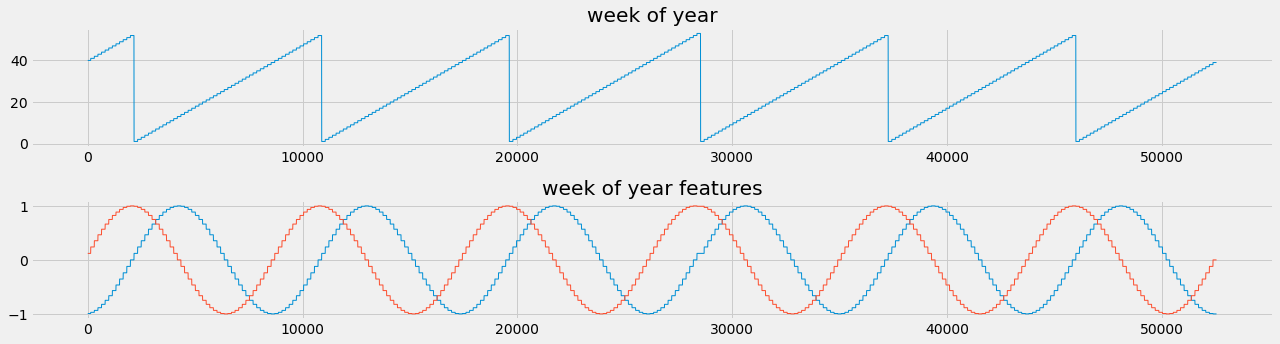

In [21]:
yearweek_sin = np.sin(2*np.pi*(df.index.week.values/52))
yearweek_cos = np.cos(2*np.pi*(df.index.week.values/52))

fig,axs = plt.subplots(2, 1, figsize=(18,5))
axs[0].plot(df.index.week,'-', lw=1)
axs[0].set_title('week of year')
axs[1].plot(yearweek_sin,'-', lw=1)
axs[1].plot(yearweek_cos,'-', lw=1)
axs[1].set_title('week of year features')
plt.tight_layout()

In [22]:
df['yearweek_sin'] = yearweek_sin
df['yearweek_cos'] = yearweek_cos

In [23]:
# drop the string features, we have now one-hot encoded these
df = df.drop(['weather_main','weather_description','holiday'],axis=1)

test_start_time  = df.index[-1] - np.timedelta64(30*6,  'D')
valid_start_time = df.index[-1] - np.timedelta64(30*12, 'D')

ranges = {
    'train': (df.index[0], valid_start_time),
    'valid': (valid_start_time, test_start_time),
    'test':  (test_start_time, df.index[-1])
}

datasets = {}
time_to_index = lambda time: np.where(df.index == time)[0][0]

datasets['train'] = df.iloc[:time_to_index(valid_start_time)]
datasets['valid'] = df.iloc[time_to_index(valid_start_time):
                            time_to_index(test_start_time)]
datasets['test']  = df.iloc[time_to_index(test_start_time):]

for key,dataset in datasets.items():
    print(dataset.shape[0], key, 'rows from', ranges[key][0], 'to', ranges[key][1])
  

43910 train rows from 2012-10-02 09:00:00 to 2017-10-05 23:00:00
4320 valid rows from 2017-10-05 23:00:00 to 2018-04-03 23:00:00
4321 test rows from 2018-04-03 23:00:00 to 2018-09-30 23:00:00


In [24]:
n_input_steps = 48
n_pred_steps  = 12

for key,dataset in datasets.items():
    dataset = datasets[key]
    n_cols = dataset.shape[1]
    dataset = dataset.values.astype(np.float64)
    
    idxs = np.arange(dataset.shape[0])
    n_timesteps = n_input_steps + n_pred_steps
    n_samples = dataset.shape[0] - n_timesteps + 1
    stride = idxs.strides[0]
    sample_idxs = np.lib.stride_tricks.as_strided(idxs, shape=(n_samples, n_timesteps), strides=(stride, stride))
    
    samples = dataset[sample_idxs]
    useable = np.all(~np.isnan(samples.reshape(-1, n_timesteps*n_cols)),axis=-1)
    s = samples[useable]
    
    print(s.shape[0], f'samples of {n_input_steps} input steps and {n_pred_steps} output steps in', key)

16625 samples of 48 input steps and 12 output steps in train
3534 samples of 48 input steps and 12 output steps in valid
4020 samples of 48 input steps and 12 output steps in test
